In [68]:
from collections import Counter, defaultdict
import json
import math
import pickle

import esm
from fairseq.models.roberta import RobertaModel
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

# Region comparison (Fig 4.1)

In [30]:
# load json
with open("030922-joint-OVA-data-Golden-EpGrp-Jac.json", "r") as f:
    data = json.load(f)
    
# build alignment
num_abs = len(data)
max_len = max([max(d["HC_AHo"]) for d in data])
alignment = np.full((num_abs, max_len), "<empty>")
for i, d in enumerate(data):
    idx = np.array(d["HC_AHo"]) - 1
    alignment[i, idx] = list(d["HC"])

# compute marginal distributions
all_aas = np.unique(alignment)[1:]  # Drop <empty>
probs = []
for col in alignment.T:
    filtered = np.delete(col, np.where(col == "<empty>"))
    cts = Counter(filtered)
    dist = {a: 0 for a in all_aas}
    for k, v in cts.items():
        dist[k] = v / len(filtered)
    probs.append(dist)
    
# calculate overall ppl
def compute_scores(alignment, probs):
    scores = []
    for i, row in enumerate(alignment):
        for aa, dist in zip(row, probs):
            if aa == "<empty>":
                continue
            else:
                try:
                    scores.append(-math.log2(dist[aa]))
                except ValueError:
                    import ipdb; ipdb.set_trace()
    return scores


scores = compute_scores(alignment, probs)            
overall_ppl = sum(scores) / (len(scores) * math.log(2))

# calculate local ppls
boundaries = {
    "fr1": (0, 25),
    "cdr1": (25, 37),
    "fr2": (37, 57),
    "cdr2": (57, 77),
    "fr3": (77, 108),
    "cdr3": (108, 137),
    "fr4": (137, 150),
}

aln_ppl = {}

for region, (start, end) in boundaries.items():
    s = start
    e = end - 1
    aln = alignment[:, s:e]
    p_ = probs[s:e]
    scores = compute_scores(aln, p_)
    aln_ppl[region] = math.pow(2, sum(scores) / (len(scores)))
aln_ppl["model"] = "alignment"

In [50]:
api = wandb.Api()
sweep = api.sweep("nickbhat/ova-perplexity/sweeps/smmy0s4z")
_d = []
for run in sweep.runs:
    metrics = run.history().to_dict()
    m = {k: v[0] for k, v in metrics.items()}
    cf = run.config
    _d.append({**m, **cf})
df = pd.DataFrame.from_dict(_d)

final_df = df[(df.mask_inside=="false") & (df.mask_outside == "false")]
final_df = final_df.drop(["_step", "_runtime", "_timestamp", "mask_inside", "mask_outside"], axis=1)

aln_df = pd.DataFrame.from_dict({k: [v] for k, v in aln_ppl.items()})
final_df = pd.concat([final_df, aln_df]).reset_index(drop=True)

<AxesSubplot:xlabel='region', ylabel='value'>

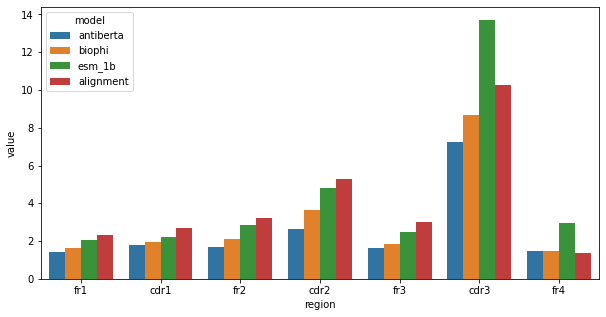

In [42]:
keep_models = ["biophi", "antiberta", "esm_1b", "alignment"]
to_plot = final_df[final_df.model.isin(keep_models)]

melted = pd.melt(
    to_plot, 
    id_vars = ["model"], 
    value_vars=["fr1", "cdr1", "fr2", "cdr2", "fr3", "cdr3", "fr4"],
)
melted = melted.rename(columns={"variable":"region"})
plt.figure(figsize=(10,5))
sns.barplot(x="region", y="value", hue="model", data=melted)
#plt.savefig("pppl_v0.png")

# ESM Comparison (Figure 4.2)

<AxesSubplot:xlabel='region', ylabel='value'>

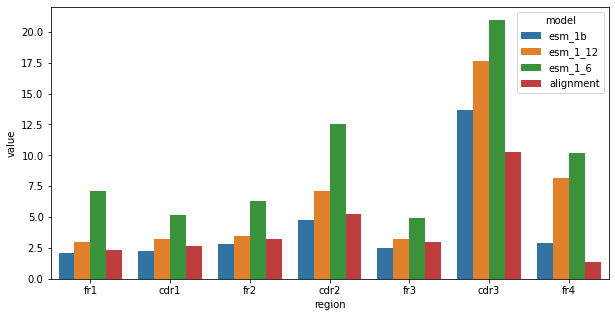

In [46]:
keep_models = ["esm_1_6", "esm_1_12", "esm_1b", "alignment"]
to_plot = final_df[final_df.model.isin(keep_models)]

melted = pd.melt(
    to_plot, 
    id_vars = ["model"], 
    value_vars=["fr1", "cdr1", "fr2", "cdr2", "fr3", "cdr3", "fr4"],
)
melted = melted.rename(columns={"variable":"region"})
plt.figure(figsize=(10,5))
sns.barplot(x="region", y="value", hue="model", data=melted)
#plt.savefig("pppl_v0.png")

# Antibody duration comparison (supplement)

<AxesSubplot:xlabel='region', ylabel='value'>

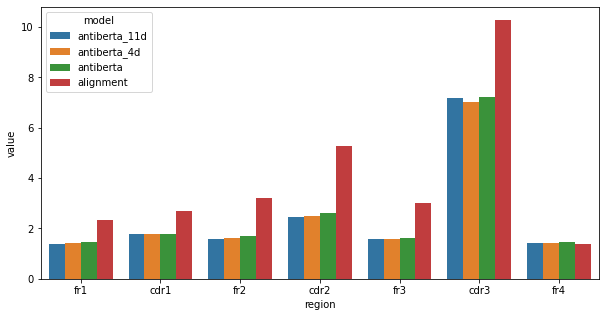

In [47]:
keep_models = ["antiberta", "antiberta_4d", "antiberta_11d", "alignment"]
to_plot = final_df[final_df.model.isin(keep_models)]

melted = pd.melt(
    to_plot, 
    id_vars = ["model"], 
    value_vars=["fr1", "cdr1", "fr2", "cdr2", "fr3", "cdr3", "fr4"],
)
melted = melted.rename(columns={"variable":"region"})
plt.figure(figsize=(10,5))
sns.barplot(x="region", y="value", hue="model", data=melted)
#plt.savefig("pppl_v0.png")

<AxesSubplot:xlabel='region', ylabel='value'>

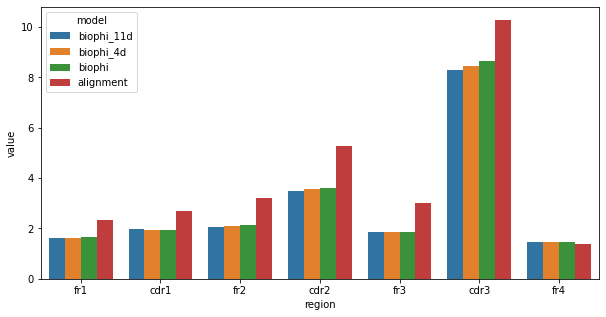

In [48]:
keep_models = ["biophi", "biophi_4d", "biophi_11d", "alignment"]
to_plot = final_df[final_df.model.isin(keep_models)]

melted = pd.melt(
    to_plot, 
    id_vars = ["model"], 
    value_vars=["fr1", "cdr1", "fr2", "cdr2", "fr3", "cdr3", "fr4"],
)
melted = melted.rename(columns={"variable":"region"})
plt.figure(figsize=(10,5))
sns.barplot(x="region", y="value", hue="model", data=melted)
#plt.savefig("pppl_v0.png")

# Local vs Global (supplement figure?)

<AxesSubplot:xlabel='region', ylabel='value'>

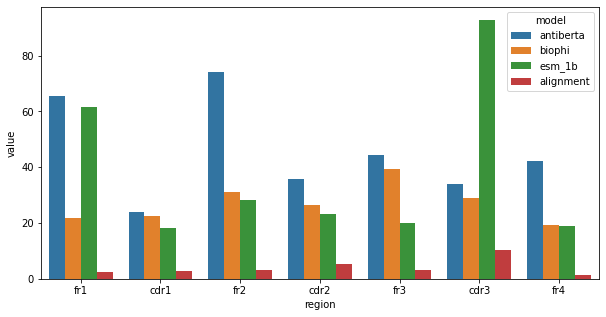

In [58]:
global_df = df[(df.mask_inside=="true") & (df.mask_outside == "false")]
global_df = global_df.drop(["_step", "_runtime", "_timestamp", "mask_inside", "mask_outside"], axis=1)

global_df = pd.concat([global_df, aln_df]).reset_index(drop=True)

keep_models = ["biophi", "antiberta", "esm_1b", "alignment"]
to_plot = global_df[global_df.model.isin(keep_models)]

melted = pd.melt(
    to_plot, 
    id_vars = ["model"], 
    value_vars=["fr1", "cdr1", "fr2", "cdr2", "fr3", "cdr3", "fr4"],
)
melted = melted.rename(columns={"variable":"region"})
plt.figure(figsize=(10,5))
sns.barplot(x="region", y="value", hue="model", data=melted)
#plt.savefig("pppl_v0.png")

(0.0, 100.0)

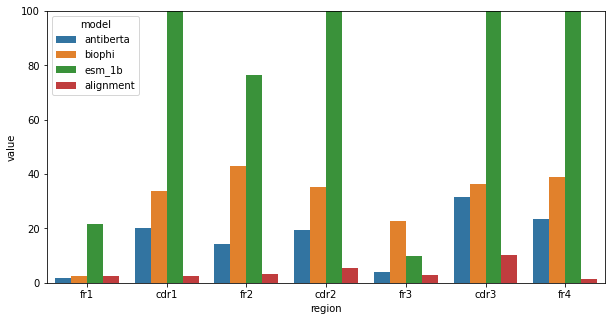

In [59]:
local_df = df[(df.mask_inside=="false") & (df.mask_outside == "true")]
local_df = local_df.drop(["_step", "_runtime", "_timestamp", "mask_inside", "mask_outside"], axis=1)

local_df = pd.concat([local_df, aln_df]).reset_index(drop=True)

keep_models = ["biophi", "antiberta", "esm_1b", "alignment"]
to_plot = local_df[local_df.model.isin(keep_models)]

melted = pd.melt(
    to_plot, 
    id_vars = ["model"], 
    value_vars=["fr1", "cdr1", "fr2", "cdr2", "fr3", "cdr3", "fr4"],
)
melted = melted.rename(columns={"variable":"region"})
plt.figure(figsize=(10,5))
sns.barplot(x="region", y="value", hue="model", data=melted)
plt.ylim(0, 100)
#plt.savefig("pppl_v0.png")

# Spatial CDR3 analysis (Figure 4.3)

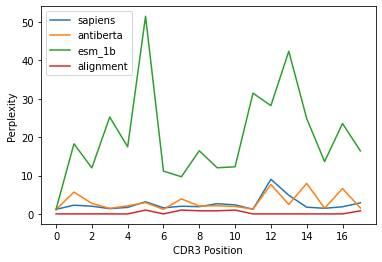

In [73]:
with open("heavy_chain_ppl.pickle", "rb") as f:
    local_ppls = pickle.load(f)

ax = plt.figure().gca()
for k, v in local_ppls.items():
    ax.plot(v[18], label=k)
ax.legend()
plt.xlabel("CDR3 Position")
plt.ylabel("Perplexity")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig("spatial_ppl_example.png")